# Kmeans  behaviour in different colors spaces
### Color Extraction to create a palette of colors from an input image
###### Multiple methods exist we ll use k-means for simplicity as a start

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from skimage.io import imread
from Palette import * 
import matplotlib.pyplot as plt
from  sklearn.metrics import pairwise_distances
from itertools import permutations

In [3]:
from skimage.color import rgb2hsv, hsv2rgb, rgb2lab, lab2rgb

In [4]:
im_pth ="./color_extraction_test/Namibia3.png"
im_rgb = imread(im_pth)
h, w =im_rgb.shape[:2]

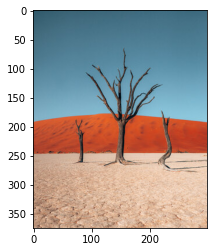

In [5]:
plt.imshow(im_rgb)
plt.show()

In [6]:
points = np.reshape(im_rgb,(h*w,3))
kmeans = KMeans(n_clusters=6, random_state=5).fit(points)
colors = kmeans.cluster_centers_

In [7]:
colors.shape


(6, 3)

In [8]:
palette_rgb = Palette(rgb = colors)

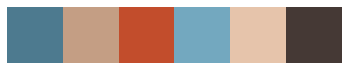

In [9]:
palette_rgb.plot_palette()
plt.show()

#### lets compare this extraction with an HSV color space extraction

In [10]:
im_hsv = rgb2hsv(im_rgb/256)

In [11]:
points = np.reshape(im_hsv,(h*w,3))
kmeans = KMeans(n_clusters=6, random_state=5).fit(points)
colors = kmeans.cluster_centers_

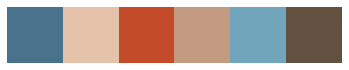

In [12]:
palette_hsv = Palette(hsv = colors)

palette_hsv.plot_palette()
plt.show()

### what about HSL space ?

##### Skimae doesn t have the RGB-HSL conversion function built-in, so let s just write it

In [13]:
def rgb2hsl(pixel): #pixel between 0 and 1 
    r,g,b = pixel[0], pixel[1], pixel[2]
    max_i = np.argmax(pixel)
    min_i = np.argmin(pixel)
    c_max = pixel[max_i]
    c_min = pixel[min_i]
    delta = c_max - c_min
    
    l = (c_min + c_max)/2
    
    if delta == 0 :
        h = 0
        s = 0
    else:
        if max_i == 0: h = 60 * ( ( (g - b)/delta )  % 6)
        elif max_i == 1: h = 60 * ( ( (b - r)/delta ) + 2)
        elif max_i == 2: h = 60 * ( ( (r - g)/delta ) + 4)
        
        s = delta / ( 1 - np.abs(2*l -1) )
        
    return np.array( [h/360,s,l] )

def hsl2rgb(pixel):
    h,s,l = pixel[0], pixel[1], pixel[2]
    
    if s == 0:
        r,g,b = l,l,l
    else:
        def hue2rgb(p,q,t):
            if t < 0 : t = t+1
            if t > 1 : t = t-1
            if t < 1/6 : return p + (q-p)*6*t
            if t < 1/2 : return q
            if t < 2/3 : return p + (q-p)*(2/3 - t)*6
            else : return p
        
        q = ( l < 0.5 ) * ( l * (1 + s)) + ( l >= 0.5 ) * (l + s - l*s)
        p = 2 * l - q
        
        r = int(hue2rgb(p,q,h + 1/3) * 255)
        g = int(hue2rgb(p,q,h) *255)
        b = int(hue2rgb(p,q,h - 1/3) * 255)
        
    return np.array([r,g,b])
        
        
        

In [14]:
points = np.reshape(im_rgb/256,(h*w,3))
for i in range(len(points)):
    points[i] = rgb2hsl(points[i])
kmeans = KMeans(n_clusters=6, random_state=5).fit(points)
colors = kmeans.cluster_centers_


In [15]:
for i in range(len(colors)):
    colors[i] = hsl2rgb(colors[i])

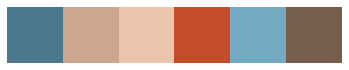

In [16]:
palette_hsl = Palette(rgb = colors)
palette_hsl.plot_palette()
plt.show()

## Finally, let's try CIELAB space

In [17]:
im_lab = rgb2lab(im_rgb/256)
points = np.reshape(im_lab,(h*w,3))
kmeans = KMeans(n_clusters=6, random_state=5).fit(points)
colors = np.floor(lab2rgb(kmeans.cluster_centers_)*256)

In [18]:
colors

array([[ 76., 122., 143.],
       [192., 153., 127.],
       [196.,  76.,  42.],
       [115., 167., 190.],
       [229., 195., 169.],
       [ 74.,  60.,  55.]])

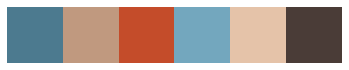

In [19]:
palette_lab = Palette(rgb = colors)
palette_lab.plot_palette()
plt.show()

## How to sort a palette ?

in order to improve visual perception ie. "some sense of continuity in color", Let s find the shortest tour around all our colors in CIELAB space

In [20]:
def sortPalette(palette):
    n_colors = len(palette)
    indices = range(n_colors)
    permuts = list(permutations(indices))
    
    lab = rgb2lab(palette)
    distance_matrix = pairwise_distances(lab,lab)
    
    min_distance = np.inf
    min_sorting = indices
    
    for i in range(len(permuts)):
        d_ = 0
        p_ = permuts[i]
        for j in range(len(p_)-1):
            d_  = d_ + distance_matrix[p_[j],p_[j+1]]
        if d_ < min_distance:
            min_distance = d_
            min_sorting = list(p_)
    
    if palette[min_sorting[0]].sum()> palette[min_sorting[-1]].sum(): #we want the most left color to be the darkest of two extremeties
        min_sorting = min_sorting[::-1]
        
    sorted_palette = palette[min_sorting]
    return sorted_palette, min_sorting, min_distance
    
    

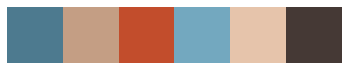

In [21]:
palette_rgb.plot_palette()
plt.show()

In [22]:
sorting, _,_  = sortPalette(palette_rgb.rgb)

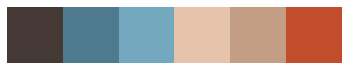

In [23]:
palette_rgb2 = Palette(rgb = sorting)

palette_rgb2.plot_palette()
plt.show()

## How to compare really ? 

In [24]:
d = {"RGB": palette_rgb.rgb, "HSV" : palette_hsv.rgb, "HSL": palette_hsl.rgb,"LAB": palette_lab.rgb}

In [25]:
def showExtractions(img , d):
    #dictionnary of "colorspace": [colors]
    
    n_palettes = len(d)
    plt.subplot(1,n_palettes + 1, 1)
    plt.imshow(img)
    plt.axis("off")
    for i, (k, v) in enumerate(d.items()):
        plt.subplot(1,n_palettes + 1, i + 2)
        indices = np.array([[ i for i in range(len(v))]])
        plt.imshow(v[indices].astype('uint8'))
        plt.axis("off")
        plt.title(k)

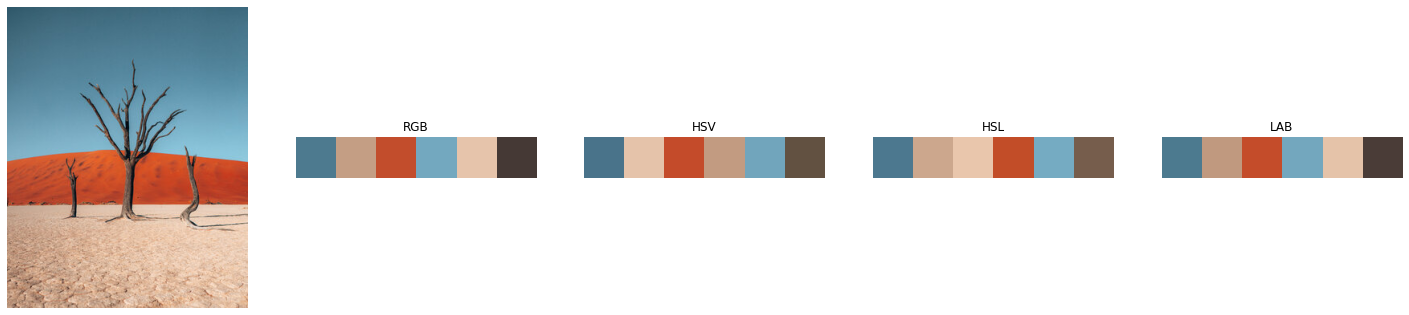

In [26]:
plt.figure(figsize= (25,18))
showExtractions(im_rgb, d)

In [27]:
def kmeansOnImage(img,n_colors):
    if len(img.shape) > 2: # check if reshape has already been done this is bad and could be changed
        h,w = img.shape[:-1]
        points = np.reshape(img,(h*w,3))
    else:
        points = img
    kmeans = KMeans(n_clusters=n_colors, random_state=5).fit(points)
    colors = kmeans.cluster_centers_
    return colors

In [28]:
def compareExtractions(img, n_colors):
    color_spaces =["RGB","HSV","HSL", "LAB"]
    summary = {}
    for s in color_spaces: 
        if  s == "RGB":
            palette_ = kmeansOnImage(img,n_colors)
            summary[s],_,_ = sortPalette(palette_)
            
        if  s == "HSV":
            palette_ = kmeansOnImage(rgb2hsv(img/256),n_colors)
            summary[s],_,_ = sortPalette(hsv2rgb(palette_) *255)
        
        if  s == "HSL":
            h,w = img.shape[:-1]
            points = np.reshape(img/256,(h*w,3))
            for i in range(len(points)):
                points[i] = rgb2hsl(points[i])
            palette_ = kmeansOnImage(points,n_colors)
            for i in range(len(palette_)):
                palette_[i] = hsl2rgb(palette_[i])
            summary[s],_,_ = sortPalette(palette_)
        
        if  s == "LAB":
            palette_ = kmeansOnImage(rgb2lab(img/256),n_colors)
            summary[s],_,_ = sortPalette(lab2rgb(palette_) * 255)
    
    plt.figure(figsize= (25,18))
    showExtractions(img, summary)
            

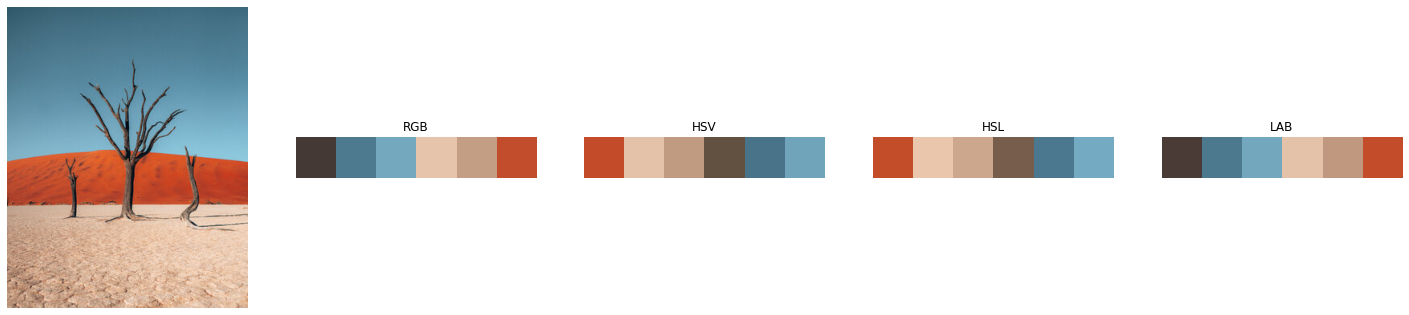

In [29]:
compareExtractions(im_rgb,6)

## Now we want to do the same but on a  folder of images:

In [30]:
import os
import fnmatch

def compareExtractionsFolder(folder, n_colors):
    for file in os.listdir(folder):
        print(file)
        if fnmatch.fnmatch(file, "*.jpg") or fnmatch.fnmatch(file, "*.jpeg") or fnmatch.fnmatch(file, "*.png") :
            try:
                im = imread(folder + file)[:,:,:3] # no need for alpha channel 
                compareExtractions(im,n_colors)
            except:
                continue
    plt.show()

9581781d-1d1d-40e9-8876-07c35627742f-Top-Drawer_Coach-House_jewels.png
arches-blond-hair-colors-1874726-820x1024.png
article_single_split.png
article_square2.png
e104cade-93e8-4b30-9ff3-9109626dd64f-Benjamin-Moore-Aura-Eggshell-In-Sharkskin_orange_colourcombos.png
f3579caa-354e-4a7a-8998-e9060cab875b-Carpetright_orange_red_colourcombos.png
grass-3085457_1280-1024x682.png
Namibia3.png
triad.png


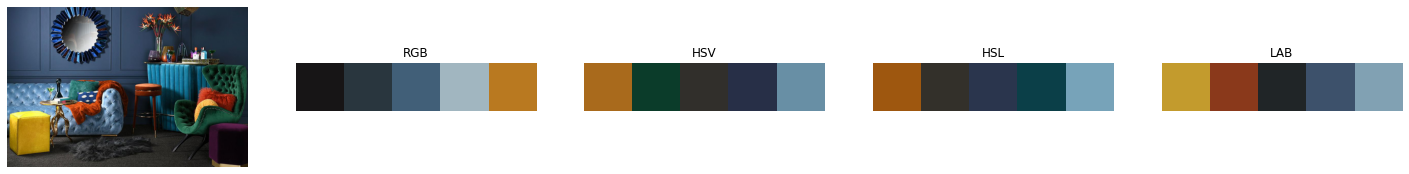

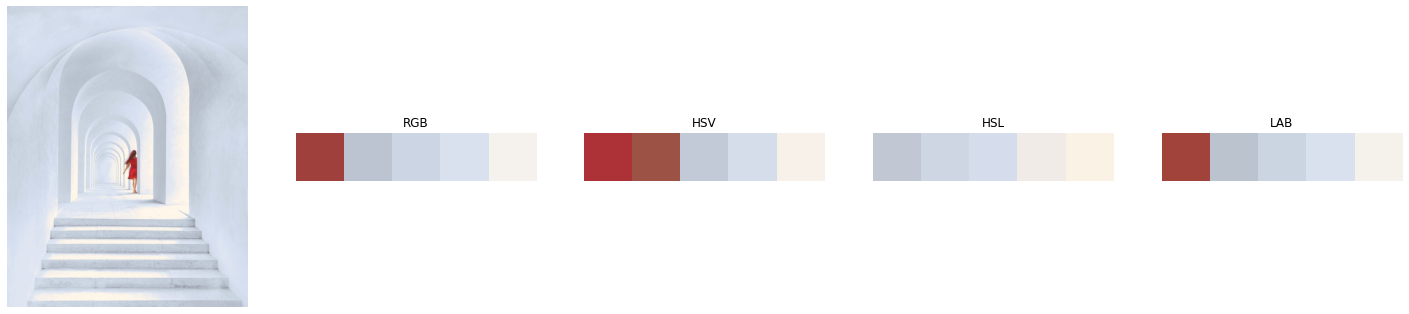

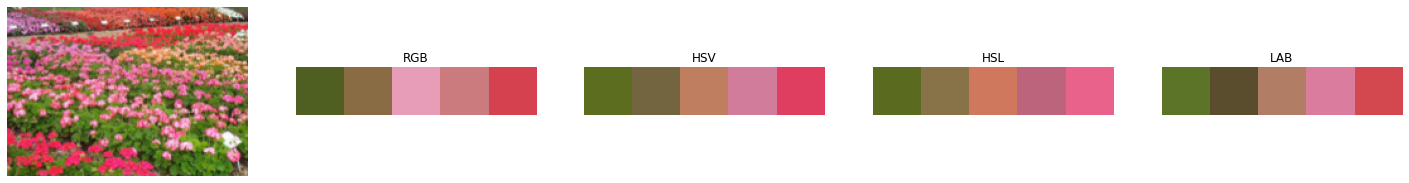

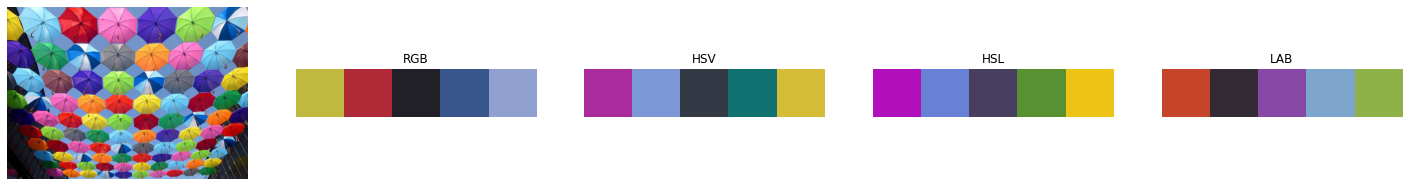

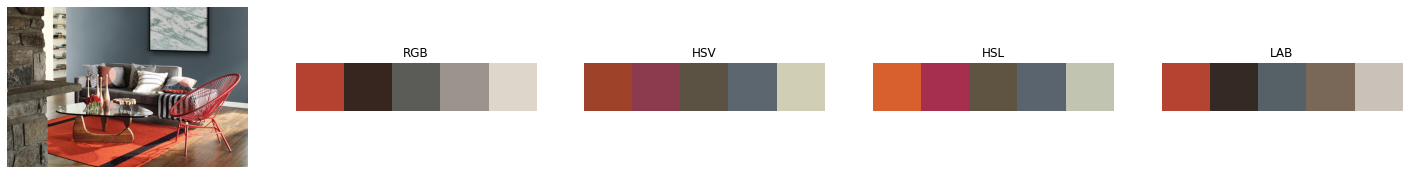

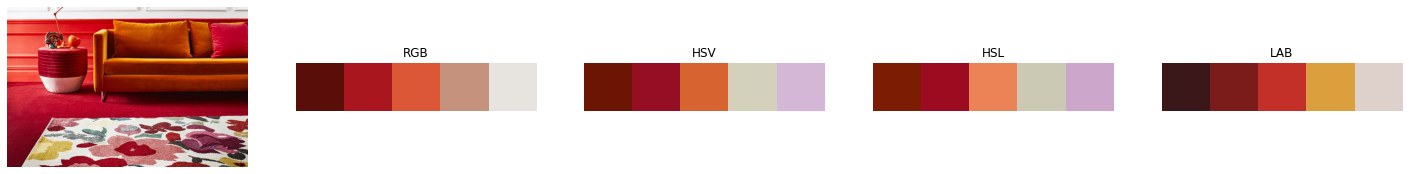

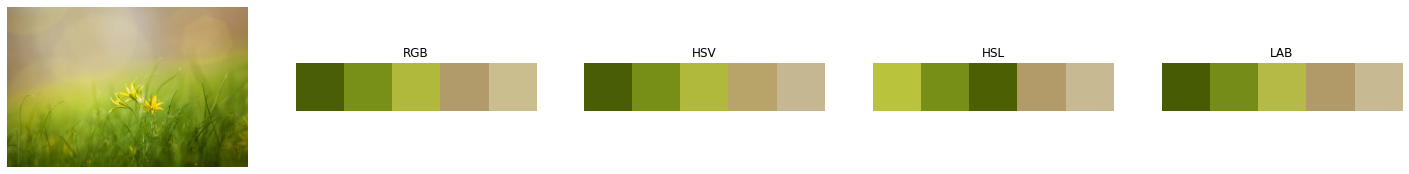

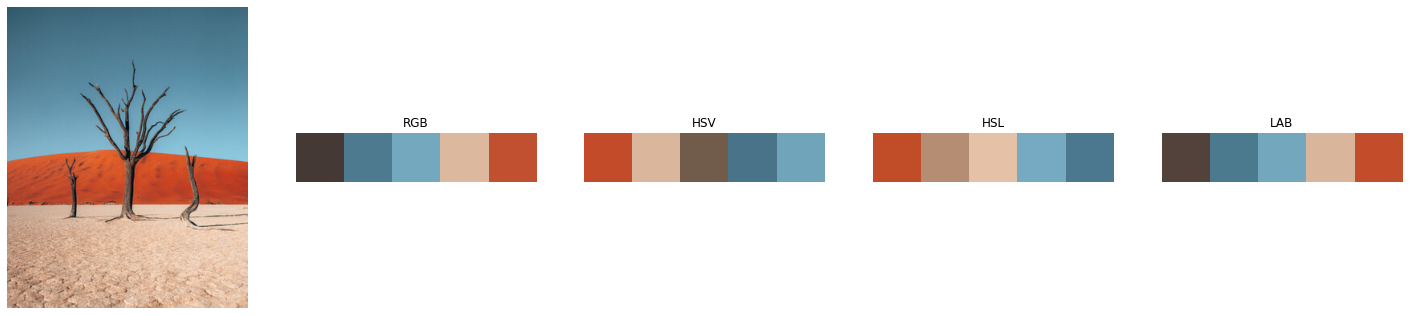

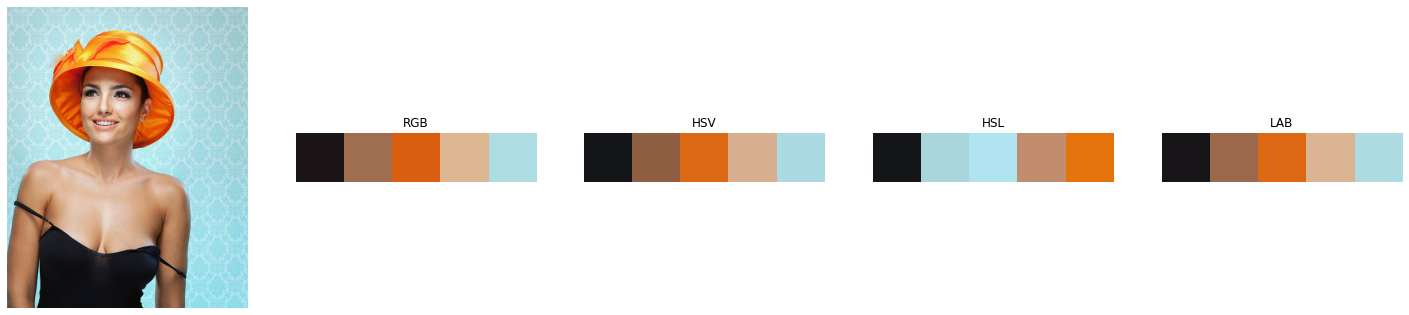

In [31]:
compareExtractionsFolder("./color_extraction_test/",5)